In [52]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler 
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, auc, precision_recall_curve, roc_auc_score

# Data Loading & Initial Exploration

In [4]:
df = pd.read_csv("loan_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# Exploratory Data Analysis (EDA)

In [10]:
print("Check null values", df.isnull().sum())
print("\nCheck duplicate values", df.duplicated().sum())

Check null values person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

Check duplicate values 0


In [13]:
df["loan_status"].value_counts()       #Shows data is imbalanced

loan_status
0    35000
1    10000
Name: count, dtype: int64

In [14]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [15]:
# Remove unrealistic ages
df = df[df['person_age'] <= 100]  

# Remove unrealistic employment experience
df = df[df['person_emp_exp'] <= 50] 

# Cap extremely high incomes
income_cap = 1000000  # 1 million
df['person_income'] = df['person_income'].clip(upper=income_cap)

print("Max age:", df['person_age'].max())
print("Max experience:", df['person_emp_exp'].max())
print("Max income:", df['person_income'].max())

Max age: 73.0
Max experience: 50
Max income: 1000000.0


# Data Visualization

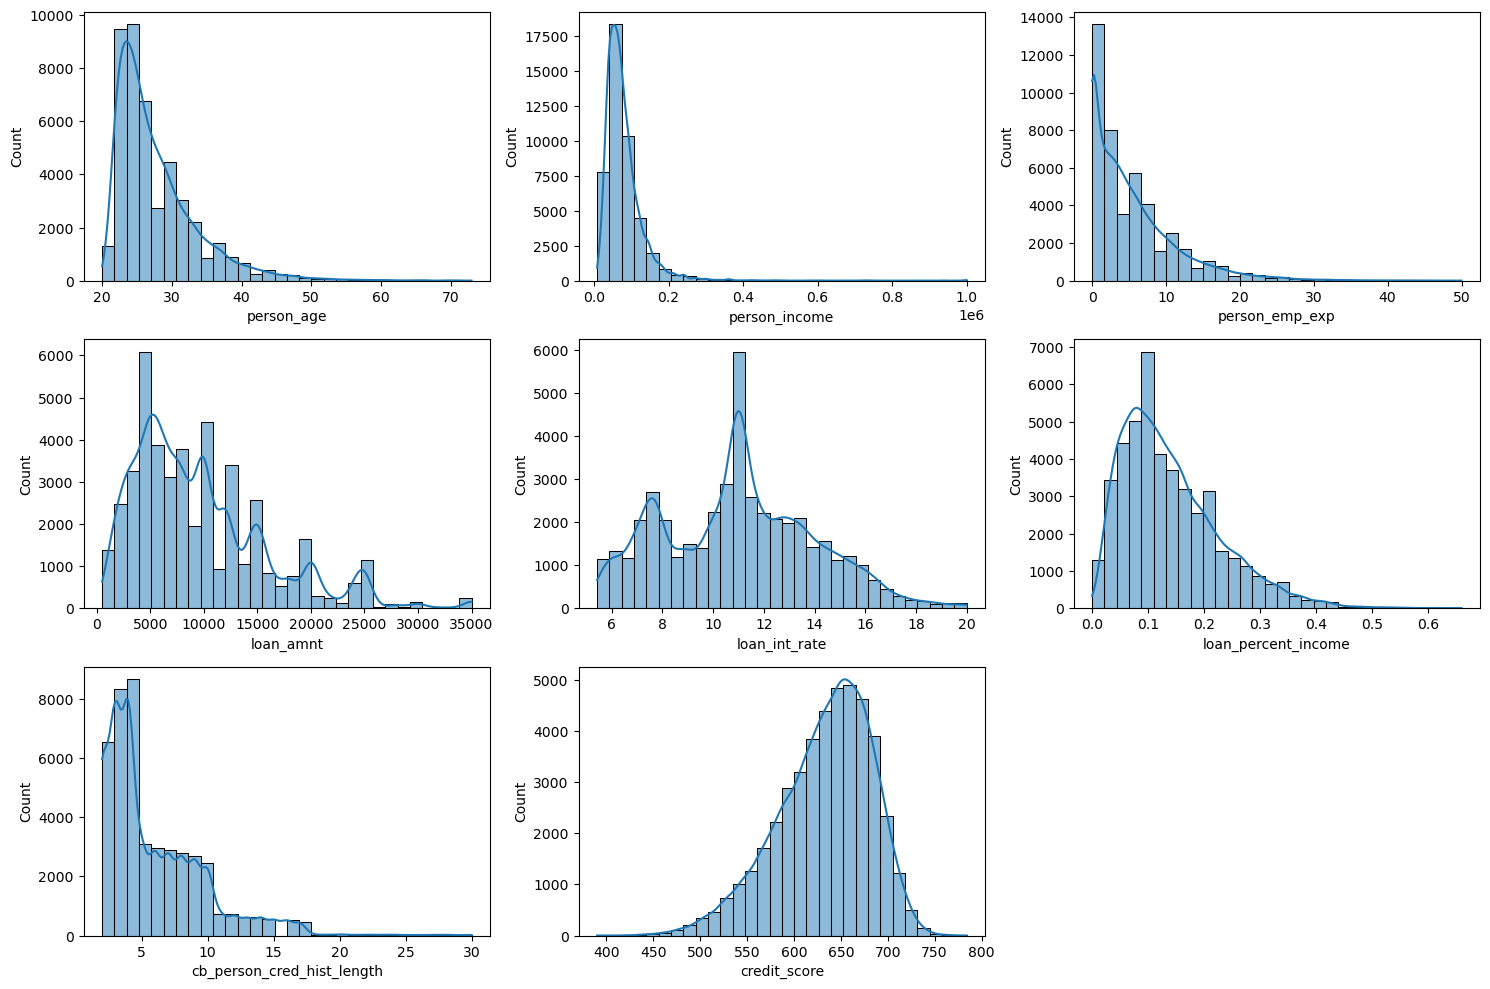

In [17]:
# Histogram
numeric_cols = ['person_age', 'person_income', 'person_emp_exp', 
                'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                'cb_person_cred_hist_length', 'credit_score']

plt.figure(figsize=(15,10))
for i,col in enumerate(numeric_cols):
    plt.subplot(3,3,i+1)
    sns.histplot(df[col], kde=True, bins=30)
plt.tight_layout()
plt.show()

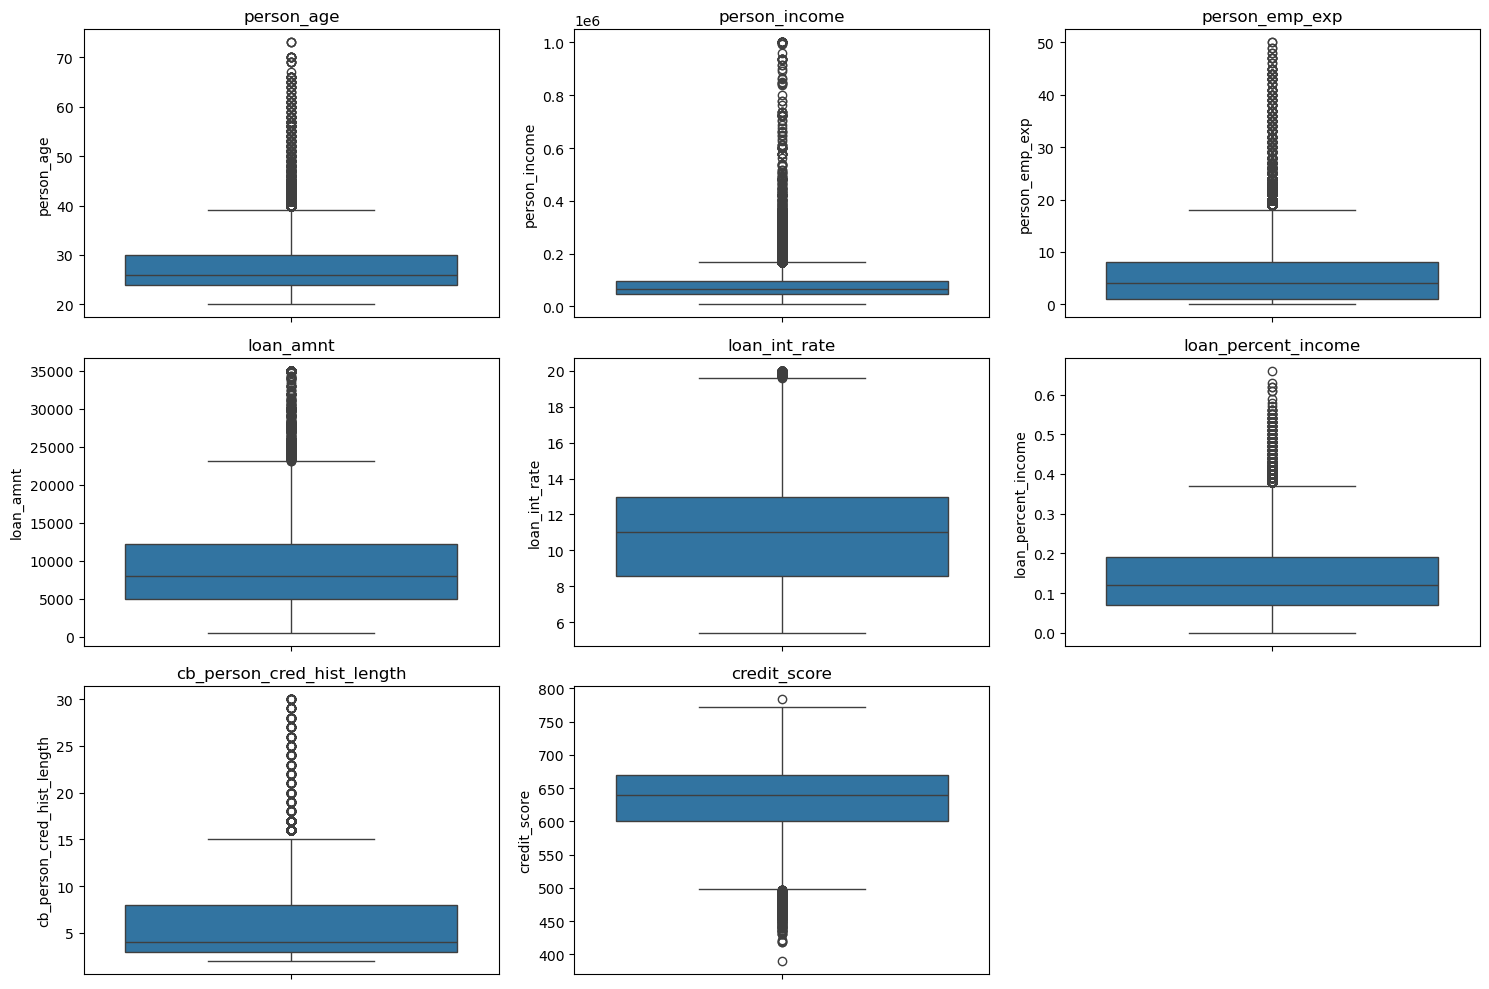

In [19]:
# Boxplot
plt.figure(figsize=(15,10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


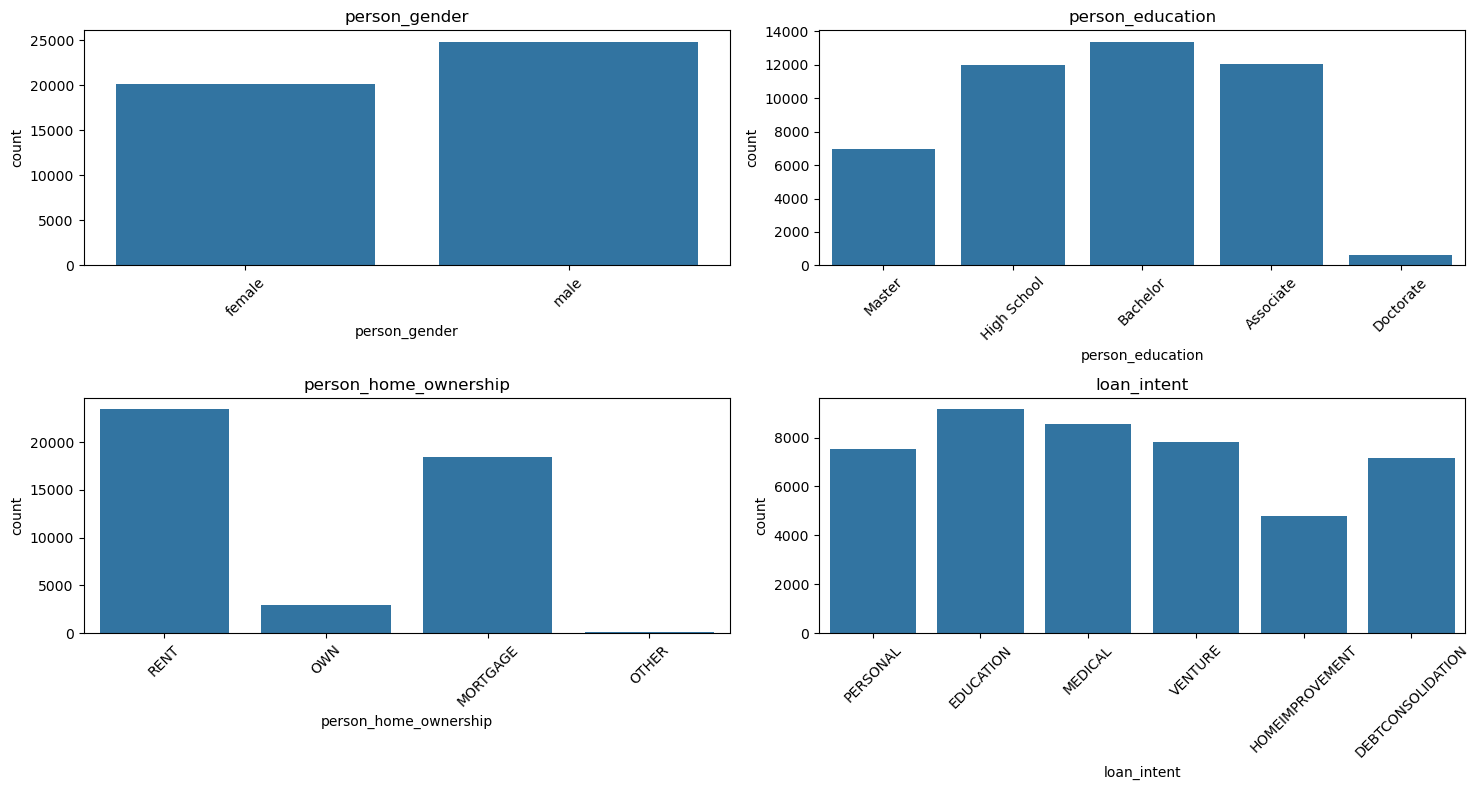

In [20]:
# Count plot
categorical_cols = ['person_gender', 'person_education', 
                    'person_home_ownership', 'loan_intent']

plt.figure(figsize=(15,8))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.title(col)
plt.tight_layout()
plt.show()

# HeatMap - Correlation

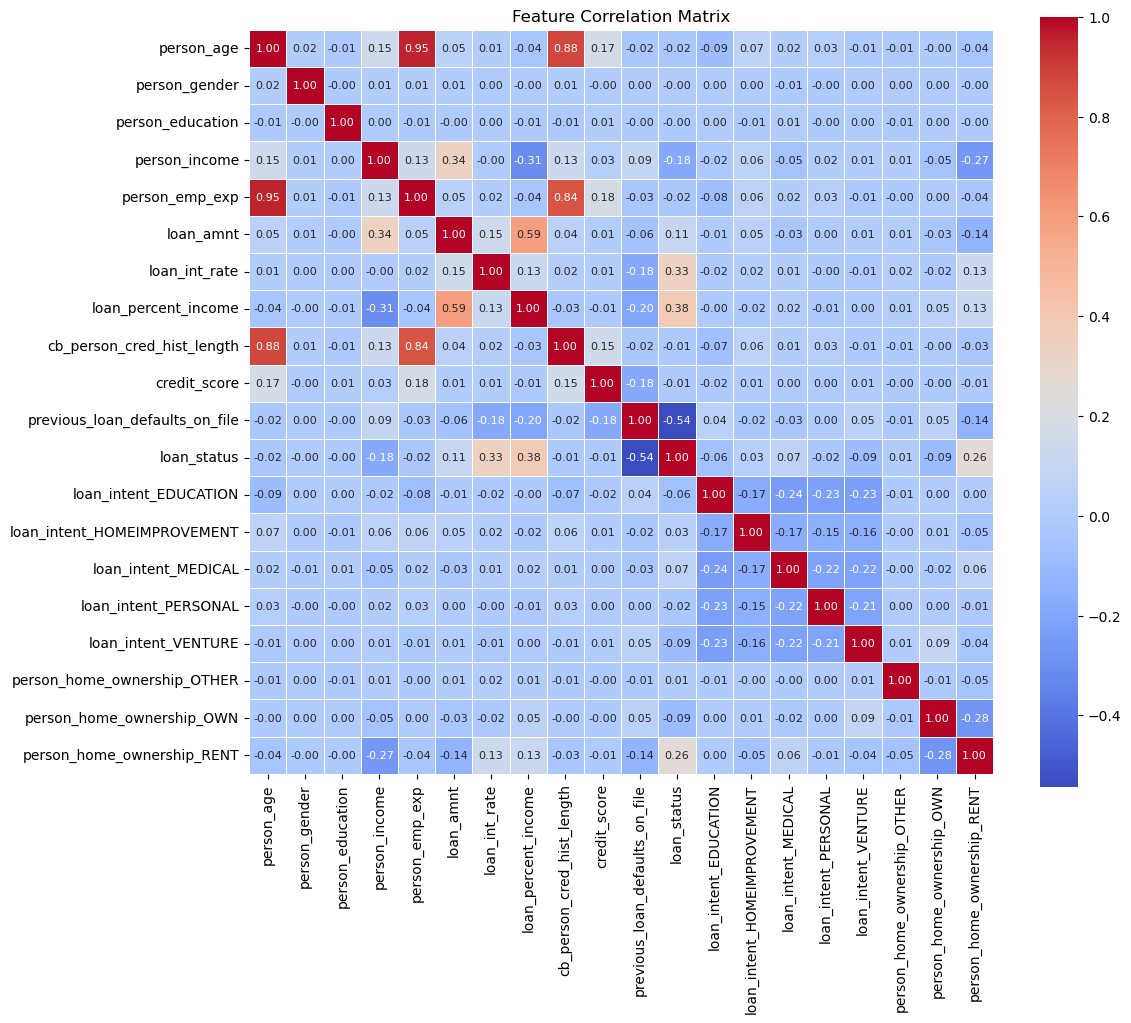

In [33]:
df_corr = df.copy()

# Encode ordinal categorical column
le = LabelEncoder()
df_corr['person_education'] = le.fit_transform(df_corr['person_education'])

# Encode binary categorical columns
df_corr['person_gender'] = le.fit_transform(df_corr['person_gender'])
df_corr['previous_loan_defaults_on_file'] = df_corr['previous_loan_defaults_on_file'].map({'Yes':1,'No':0})

# Optional: one-hot encode multi-category columns
df_corr = pd.get_dummies(df_corr, columns=['loan_intent','person_home_ownership'], drop_first=True)

# Now compute correlation
corr_matrix = df_corr.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True,
            linewidths=0.5, annot_kws={"size":8})
plt.title("Feature Correlation Matrix")
plt.show()


# Data Split

In [23]:
X = df.drop("loan_status",axis=True)
y = df["loan_status"]

# Split dataset: 70% train, 30% test, stratify to keep class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Check shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (31491, 13)
X_test: (13497, 13)
y_train: (31491,)
y_test: (13497,)


# Data Preprocessing

In [25]:
# Label Encoding for 'person_education' (High School < Bachelor < Master)
le = LabelEncoder()
X_train['person_education'] = le.fit_transform(X_train['person_education'])
X_test['person_education'] = le.transform(X_test['person_education'])

print(dict(zip(le.classes_, le.transform(le.classes_))))

# One-Hot Encoding for other categorical columns
one_hot_cols = ['person_gender', 'loan_intent', 'person_home_ownership']

# Use ColumnTransformer to apply OneHotEncoder only to categorical columns
ct = ColumnTransformer(
    transformers=[('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), one_hot_cols)], remainder='passthrough'  # keep other columns
)

# Fit on train, transform both train and test
X_train_encoded = ct.fit_transform(X_train)
X_test_encoded = ct.transform(X_test)

# Convert back to DataFrame 
ohe_columns = ct.named_transformers_['ohe'].get_feature_names_out(one_hot_cols)
other_columns = [col for col in X_train.columns if col not in one_hot_cols]
X_train_encoded = pd.DataFrame(X_train_encoded, columns=list(ohe_columns) + other_columns)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=list(ohe_columns) + other_columns)

# Convert boolean / Yes-No columns 
bool_cols_train = X_train_encoded.select_dtypes('bool').columns
X_train_encoded[bool_cols_train] = X_train_encoded[bool_cols_train].astype(int)
X_test_encoded[bool_cols_train] = X_test_encoded[bool_cols_train].astype(int)

# Convert Yes/No to 1/0
X_train_encoded['previous_loan_defaults_on_file'] = X_train_encoded['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})
X_test_encoded['previous_loan_defaults_on_file'] = X_test_encoded['previous_loan_defaults_on_file'].map({'Yes': 1, 'No': 0})

# Check first 5 rows of train
X_train_encoded.head()


{'Associate': np.int64(0), 'Bachelor': np.int64(1), 'Doctorate': np.int64(2), 'High School': np.int64(3), 'Master': np.int64(4)}


,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,23.0,0,76732.0,2,18000.0,10.99,0.23,3.0,618,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,33.0,2,137660.0,9,5000.0,11.83,0.04,9.0,706,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,31.0,1,42986.0,7,11700.0,13.06,0.27,9.0,700,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,3,123742.0,4,13600.0,6.62,0.11,3.0,600,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0,75765.0,10,3700.0,6.39,0.05,6.0,687,0


# Scaling for Logistic Regression

In [26]:
# Select numeric columns
num_cols = ['person_age','person_income','person_emp_exp','loan_amnt',
            'loan_int_rate','loan_percent_income','cb_person_cred_hist_length','credit_score']

scaler = RobustScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_encoded[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test_encoded[num_cols])

# Check first 5 rows of train
X_train_scaled.head()

,person_gender_male,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.500000,0,0.198589,-0.285714,1.394408,-0.004545,0.916667,-0.2,-0.308824,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.166667,2,1.448548,0.714286,-0.418323,0.186364,-0.666667,1.0,0.985294,0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.833333,1,-0.493722,0.428571,0.515931,0.465909,1.250000,1.0,0.897059,0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.333333,3,1.163015,0.000000,0.780869,-0.997727,-0.083333,-0.2,-0.573529,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.166667,0,0.178750,0.857143,-0.599596,-1.050000,-0.583333,0.4,0.705882,0


# Model 1 - Logistic Regression

In [34]:
# Initialize LR with class weight for imbalance
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Train
lr_model.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob = lr_model.predict_proba(X_test_scaled)[:,1]

# Use threshold 0.5 first
y_pred = (y_prob >= 0.5).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8581166185078165

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90     10497
           1       0.62      0.91      0.74      3000

    accuracy                           0.86     13497
   macro avg       0.80      0.88      0.82     13497
weighted avg       0.89      0.86      0.87     13497


Confusion Matrix:
 [[8848 1649]
 [ 266 2734]]


# Threshold tuning for LR

In [36]:
thresholds = [0.55, 0.6, 0.65]

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    print(f"\n--- Threshold = {t} ---")
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))


--- Threshold = 0.55 ---
[[9029 1468]
 [ 317 2683]]
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     10497
           1       0.65      0.89      0.75      3000

    accuracy                           0.87     13497
   macro avg       0.81      0.88      0.83     13497
weighted avg       0.90      0.87      0.87     13497


--- Threshold = 0.6 ---
[[9221 1276]
 [ 380 2620]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92     10497
           1       0.67      0.87      0.76      3000

    accuracy                           0.88     13497
   macro avg       0.82      0.88      0.84     13497
weighted avg       0.90      0.88      0.88     13497


--- Threshold = 0.65 ---
[[9397 1100]
 [ 479 2521]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     10497
           1       0.70      0.84      0.76      3000

    accuracy            

# Interpret Coefficient

In [37]:
coef_df = pd.DataFrame({'feature': X_train_scaled.columns, 'coefficient': lr_model.coef_[0]})
coef_df = coef_df.sort_values(by='coefficient', ascending=False)
print(coef_df)

                           feature  coefficient
15             loan_percent_income     2.054335
14                   loan_int_rate     1.447260
8       person_home_ownership_RENT     0.679669
11                   person_income     0.191702
6      person_home_ownership_OTHER     0.106644
9                       person_age     0.099446
10                person_education    -0.006429
0               person_gender_male    -0.019531
16      cb_person_cred_hist_length    -0.034138
2      loan_intent_HOMEIMPROVEMENT    -0.058668
12                  person_emp_exp    -0.069050
3              loan_intent_MEDICAL    -0.247286
17                    credit_score    -0.585960
4             loan_intent_PERSONAL    -0.669505
13                       loan_amnt    -0.872148
1            loan_intent_EDUCATION    -0.888002
7        person_home_ownership_OWN    -1.305436
5              loan_intent_VENTURE    -1.390488
18  previous_loan_defaults_on_file    -8.399805


# Model 2 - Random Forest

In [40]:
# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,        # number of trees
    random_state=42,
    class_weight=None       
)

# Train the model
rf_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_encoded)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9275394532118248

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95     10497
           1       0.90      0.76      0.82      3000

    accuracy                           0.93     13497
   macro avg       0.92      0.87      0.89     13497
weighted avg       0.93      0.93      0.93     13497


Confusion Matrix:
 [[10242   255]
 [  723  2277]]


# Threshold tuning for Random Forest

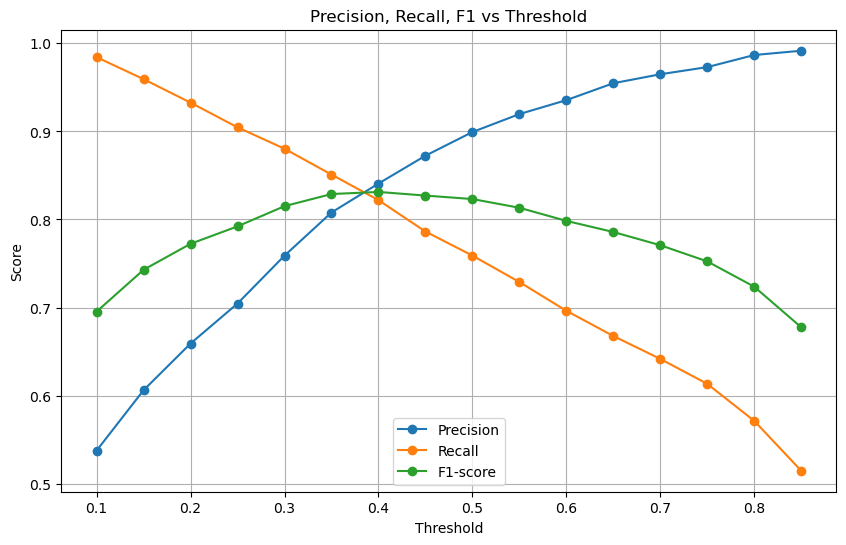

In [41]:
# Get predicted probabilities for class 1
y_prob = rf_model.predict_proba(X_test_encoded)[:,1]

# Define thresholds to test
thresholds = np.arange(0.1, 0.9, 0.05)

# Lists to store metrics
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Plot precision, recall, and F1 vs threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Get predicted probabilities for class 1 (approved loans)
y_prob = rf_model.predict_proba(X_test_encoded)[:, 1]

threshold = 0.35
y_pred_threshold = (y_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Evaluate the model with the new threshold
print("Classification Report (Threshold = 0.35):\n")
print(classification_report(y_test, y_pred_threshold))

print("Confusion Matrix (Threshold = 0.35):\n")
print(confusion_matrix(y_test, y_pred_threshold))

Accuracy: 0.8911609987404608
Classification Report (Threshold = 0.35):

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10497
           1       0.80      0.86      0.83      3000

    accuracy                           0.92     13497
   macro avg       0.88      0.90      0.89     13497
weighted avg       0.92      0.92      0.92     13497

Confusion Matrix (Threshold = 0.35):

[[9839  658]
 [ 423 2577]]


# Model 3 - XGBoost

In [46]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]

scale_pos_weight = neg / pos
print("Scale pos weight", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    reg_alpha=0.5,    # L1 regularization
    reg_lambda=1,      # L2 regularization
    random_state=42,
    eval_metric='logloss'
)

# Ensure all columns are numeric
X_train_numeric = X_train_encoded.apply(pd.to_numeric)
X_test_numeric = X_test_encoded.apply(pd.to_numeric)

# Train
xgb_model.fit(X_train_numeric, y_train)

# Predict
y_pred = xgb_model.predict(X_test_numeric)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Scale pos weight 3.4987142857142857
Accuracy: 0.8940505297473512

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93     10497
           1       0.70      0.91      0.79      3000

    accuracy                           0.89     13497
   macro avg       0.84      0.90      0.86     13497
weighted avg       0.91      0.89      0.90     13497


Confusion Matrix:
 [[9329 1168]
 [ 262 2738]]


# Threshold tuning for XGBoost

In [47]:
# probabilities for class 1
y_prob = xgb_model.predict_proba(X_test_numeric)[:, 1]

thresholds = [0.55, 0.60, 0.65, 0.70]

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)

    print(f"\n--- Threshold = {t} ---")
    print(confusion_matrix(y_test, y_pred_t))
    print(classification_report(y_test, y_pred_t))


--- Threshold = 0.55 ---
[[9485 1012]
 [ 303 2697]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     10497
           1       0.73      0.90      0.80      3000

    accuracy                           0.90     13497
   macro avg       0.85      0.90      0.87     13497
weighted avg       0.92      0.90      0.91     13497


--- Threshold = 0.6 ---
[[9672  825]
 [ 366 2634]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     10497
           1       0.76      0.88      0.82      3000

    accuracy                           0.91     13497
   macro avg       0.86      0.90      0.88     13497
weighted avg       0.92      0.91      0.91     13497


--- Threshold = 0.65 ---
[[9855  642]
 [ 441 2559]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     10497
           1       0.80      0.85      0.83      3000

    accuracy            

# Feature Importance from XGBoost

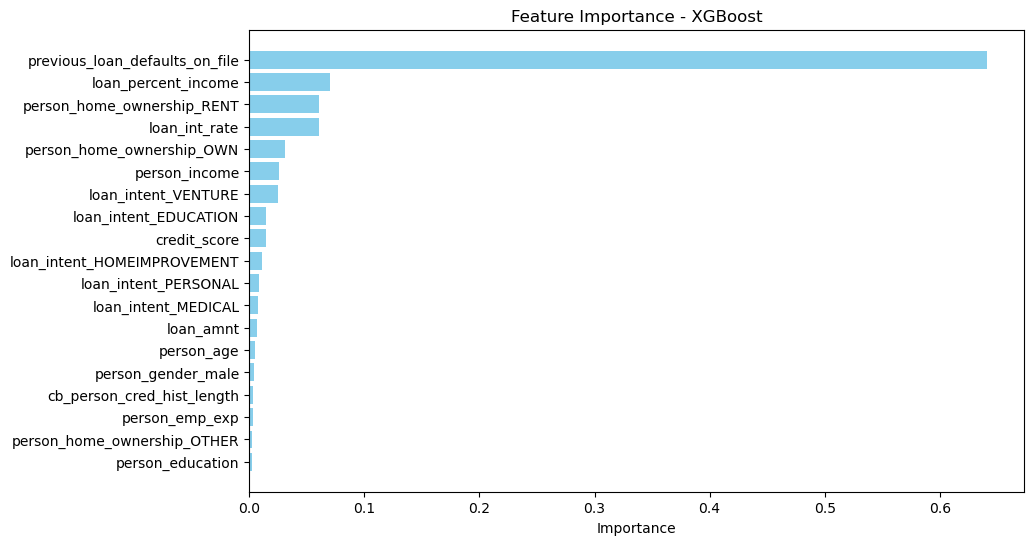

In [49]:
# Get feature importance from XGBoost
importance = xgb_model.feature_importances_
features = X_train_numeric.columns

# Create a DataFrame for easier plotting
fi_df = pd.DataFrame({'feature': features, 'importance': importance})
fi_df = fi_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
plt.barh(fi_df['feature'], fi_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance - XGBoost")
plt.show()

# Calculated ROC-AUC and PR-AUC from XGB

ROC-AUC: 0.9729512559143884
PR-AUC: 0.9254190386939553


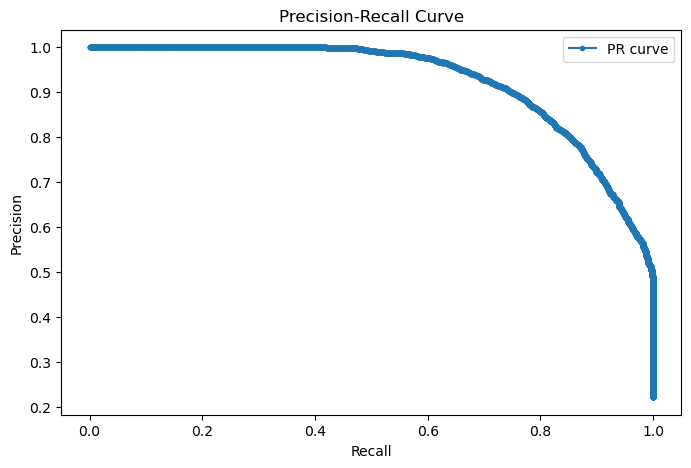

In [50]:
# Probabilities for class 1
y_prob = xgb_model.predict_proba(X_test_numeric)[:,1]

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", roc_auc)

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# Optional: plot PR curve
plt.figure(figsize=(8,5))
plt.plot(recall, precision, marker='.', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# Save trained XGBoost Model

In [53]:
# Save the trained XGBoost model
with open('xgb_loan_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the scaler (numeric features)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully!")

Model and scaler saved successfully!
